In [1]:
# Import nessessary packages and functions
import torch
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from torchvision import datasets, transforms


from Utility.visualizer import single_image
from sklearn.metrics import confusion_matrix
from Utility.cnn_model import FashionMNISTModel


device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load Data from torchvision.datasets
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
class_names = test_data.classes

# Load Model for Evaluation & Visualization
MODEL_SAVE_PATH = Path("models/fashion_mnist_model.pth")
loaded_model = FashionMNISTModel(input_shape=1, hidden_units=10, output_shape=len(class_names))
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model.to(device)

FashionMNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

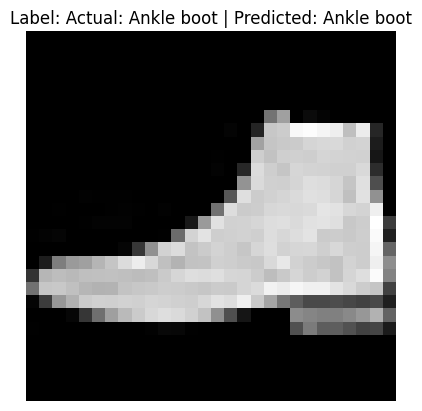

In [3]:
# Visualize a random image
random_idx = random.randint(0, len(test_data) - 1)
image, label = test_data[random_idx]
actual_class = class_names[label]

loaded_model.eval()
torch_image = image.unsqueeze(0).to(device)
with torch.inference_mode():
    output = loaded_model(torch_image)
    predicted_label = torch.argmax(output, dim=1)  # Get the index of the highest logit
    predicted_class = class_names[predicted_label.item()]

label = f"Actual: {actual_class} | Predicted: {predicted_class}"
single_image(image, label) # Visualize image and preditction

In [4]:
# Predict all testing data for model evaluation
all_preds = []
all_labels = []
misclassified_images = []
misclassified_true_labels = []
misclassified_pred_labels = []


loaded_model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = loaded_model(images)
        _, preds = torch.max(outputs, 1)
        
        # Append predictions and true labels for confusion matrix
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        # Collect misclassified examples
        incorrect_indices = preds != labels
        if incorrect_indices.any():
            misclassified_images.append(images[incorrect_indices].cpu())
            misclassified_true_labels.append(labels[incorrect_indices].cpu())
            misclassified_pred_labels.append(preds[incorrect_indices].cpu())
            
# Concatenate all predictions and true labels for confusion matrix
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Concatenate all misclassified images and labels
misclassified_images = torch.cat(misclassified_images)
misclassified_true_labels = torch.cat(misclassified_true_labels)
misclassified_pred_labels = torch.cat(misclassified_pred_labels)

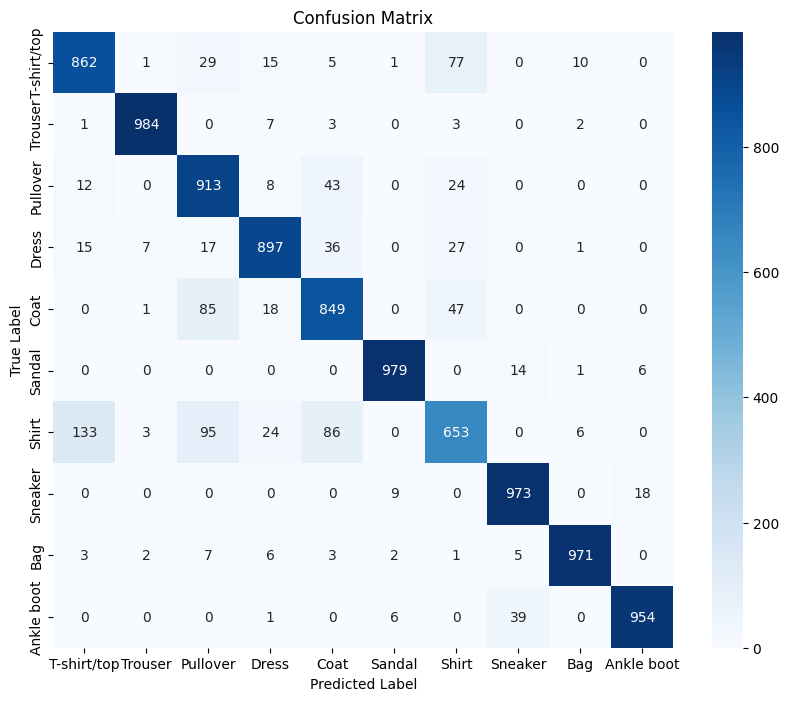

In [5]:
# Create a confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

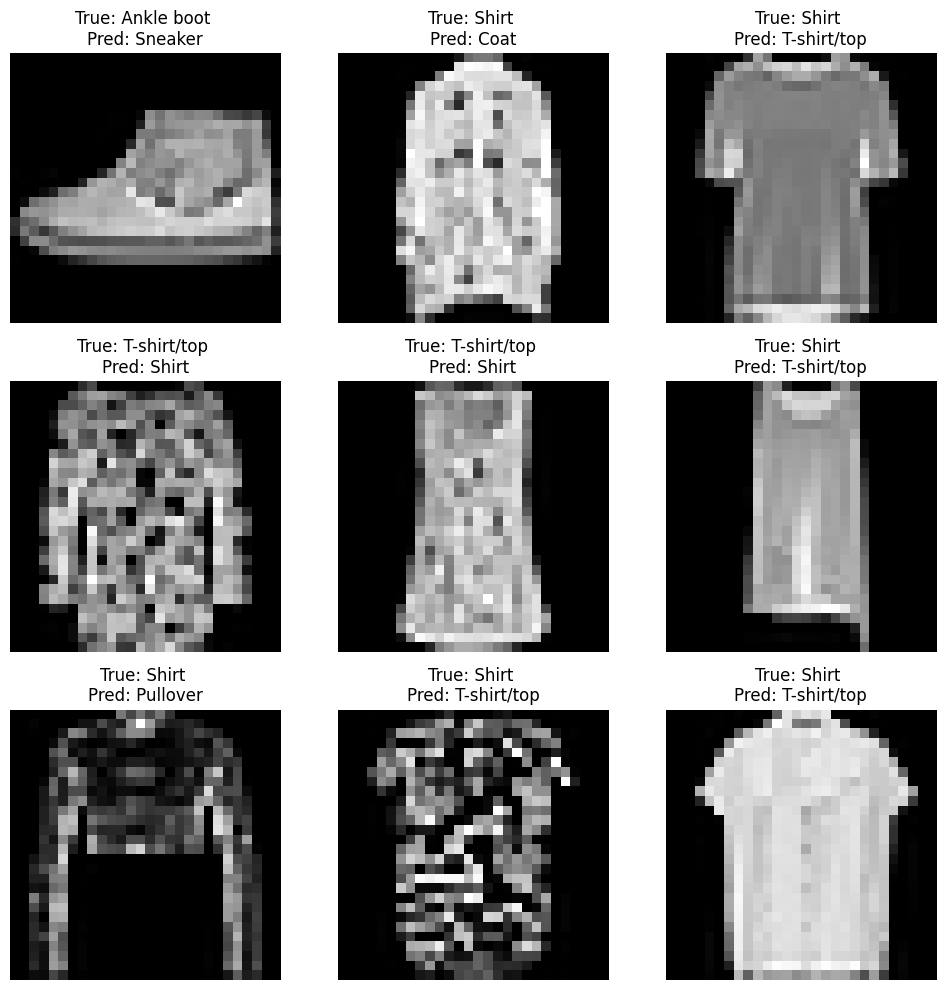

In [7]:
# Randomly select 9 misclassified images (or less if there are fewer than 9)
num_images = min(9, len(misclassified_images))
random_indices = random.sample(range(len(misclassified_images)), num_images)

random_misclassified_images = misclassified_images[random_indices]
random_misclassified_true_labels = misclassified_true_labels[random_indices]
random_misclassified_pred_labels = misclassified_pred_labels[random_indices]

# Plot 3x3 grid of misclassified images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for img, true_label, pred_label, ax in zip(random_misclassified_images, random_misclassified_true_labels, random_misclassified_pred_labels, axes):
    img = img.squeeze()  # Remove the batch dimension and channel dimension (since it's grayscale)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"True: {class_names[true_label]} \nPred: {class_names[pred_label]}")
    ax.axis('off')

plt.tight_layout()
plt.show()